# Data generation and analysis for ensemble methods

## Imports

In [3]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd

#import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, log_loss

#sklearn imports
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn import datasets

#import XGBoost
import xgboost as xgb

# import Deep Learning Libraries for feature extraction
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import VGG16

## Data generation

Unlike the case for Convolutional Neural Networks, the (224, 224, 3) arrays as given by img_to_array are stored in a list "images", which is itself then converted to a numpy array named "pixelvals" of size (811, 224, 224, 3) (as our dataset contains 811 images).

"Labels" is a (811,) numpy array containing 6 different strings, one for each bird species. When LabelEncoder is applied to it to produce "categories", each of these strings is replaced by a corresponding value from 0 to 5 (and the array is also reshaped to be of size (811,1). These are the targets for our ensemble methods.

A root directory named "Results_Ensemble" is created for saving the results of our analysis. The data is then sent through only the convolutional and pooling layers of VGG16 (include_top = False ensures this), with the weights that were obtained from training the network in the "imagenet" dataset. The (811, 7, 7, 512) network output is reshaped to an (811, 25088) array, which contains the inputs for our ensemble methods and is named "features".

"categories" and "features" are both saved in separate files for use in later cells.

In [4]:
#------------------------------------- GENNING DATA -------------------#
data_dir = 'Bird_Species_Dataset' 

filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)


for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)


for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)/255 
    # converts the image to an array, reshapes it to (1, n_features) and scales by 255, all in one go
    image_list.append(image)
    
# Create arrays out of the previously made lists, to use with XGBoost
pixelvals =  np.array(image_list)
labels = np.array(label_list)


#Create a LabelEncoder() instance
#Converts the names of the birds to numbers (0, 1, 2, 3, 4 or 5)
labelencoder = LabelEncoder()
categories = labelencoder.fit_transform(labels).reshape(-1,1)


#------------------CREATE A FOLDER TO SAVE THE RESULTS------------------#
PROJECT_ROOT_DIR = "Results_Ensemble"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)
np.save(PROJECT_ROOT_DIR + '/categories.npy', categories)


VGG_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
for layer in VGG_model.layers:
    layer.trainable = False


VGG_model.summary()

feature_extractor = VGG_model.predict(pixelvals)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

np.save(PROJECT_ROOT_DIR + '/features.npy', features)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

26/26 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step


## Functions for cross validation

Two functions are defined in the cell below, to run GridSearchCV on either of RandomForestClassifier or XGBClassifier.

The first is equipped to deal with grids for the "max_depth" and "n_estimators" parameters, i.e., the max depth of each tree and the total number of trees. The Random Forests are all initiated with "random_state = 123" (for reproducibility), and their splitting criterion = "entropy".

The second is equipped to deal with grids for the "learning_rate" and "reg_lambda" parameters, i.e., the learning rate and the L2 regularization parameter. The XGBClassifiers are all initiated with "random_state = 123" (for reproducibility), "n_estimators = 100" (default settings), max_depth = 1 (not default, but speeds up training and doesn't significantly affect results). 

Both functions save:

* The results from the cross validation in a .csv file;
* A .txt file containing information about the best parameters, the best validation accuracy and the index positions of the best parameters in the grid;

These files are saved in new directories contained within the root "Results_Ensemble" directory: "crossval_RF" and "crossval_XGB", respectively.

In [30]:
def GridSearchRF(x_train, y_train, n_folds, depth_vals, estimator_vals):
    """
    defines a function to perform cross validation with n-folds over 
    different values for max_depth.
    
    x_train, y_train: features and targets of the training data (some of it is used for validation at each k-fold instance)
    n_folds: number of folds to perform cross validation
    depth_vals: numpy array containing the desired max_depths for grid searching
    """
    
    param_grid = {"max_depth" : depth_vals}
    
    model = RandomForestClassifier(random_state = 123, criterion = "entropy", n_estimators = 100)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_folds, scoring='accuracy', verbose=3)

    grid_search.fit(x_train, y_train)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "GridSearchRF")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_csv = results_df.to_csv(FILE_PATH + "/crossval_RF.csv")

    """
    saving the best accuracy score, max_depth  and its index for plotting and 
    for use in LossAccuracyOverEstimators
    """
    
    test_array =  np.zeros(len(depth_vals))
    
    best_acc = grid_search.best_score_
    best_params = grid_search.best_params_
    best_index =  np.unravel_index(grid_search.best_index_, test_array.shape)
    
    print(best_acc, best_params, best_index)
    
    
    
    with open(FILE_PATH + "/Best_settings_RF.txt", "w") as file:
        file.write(f"Best value: Depth = {best_params['max_depth']}\n")
        file.write(f"Best validation accuracy: {best_acc}\n")
        file.write(f"Best index: {best_index}")        
   

def GridSearchXGboost(x_train, y_train, n_folds, eta_vals, lambda_vals):
    """
    defines a function to perform cross validation with n-folds over 
    a grid of values for the learning rate and the L2 regularization.
    
    x_train, y_train: features and targets of the training data (some of it is used for validation at each k-fold instance)
    n_folds: number of folds to perform cross validation
    eta_vals, lambda_vals: numpy arrays containing the desired Learning rates and L2 regs. for grid searching
    """
    param_grid = {"learning_rate" : eta_vals, "reg_lambda": lambda_vals}
    
    
    model = xgb.XGBClassifier(max_depth = 1, random_state = 123, n_estimators = 100)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_folds, scoring='accuracy', verbose=3)

    
    grid_search.fit(x_train, y_train)

    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "GridSearchXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_csv = results_df.to_csv(FILE_PATH + "/crossval_XGB.csv")
    
    """
    saving the best accuracy score, (eta,lambda) pair  and its index for plotting and 
    for use in LossAccuracyOverRounds
    """
    
    test_array = np.zeros( ( len(eta_vals), len(lambda_vals) ) )
    
    best_acc = grid_search.best_score_
    best_params = grid_search.best_params_
    best_index =  np.unravel_index(grid_search.best_index_, test_array.shape)
    
    print(best_acc, best_params, best_index)
    
    with open(FILE_PATH + "/Best_settings_XGB.txt", "w") as file:
        file.write(f"Best value: L.R. = {best_params['learning_rate']}, L2 = {best_params['reg_lambda']}\n")
        file.write(f"Best validation accuracy: {best_acc}\n")
        file.write(f"Best indices: {best_index}")

## Functions for evaluation over iterations

Two functions are defined in the cell below:

* LossAccuracyOverEstimators checks the cross-entropy and the accuracy over the number of estimators in a RandomForestClassifier model, for both training and testing data;
* LossAccuracyOverRounds checks the cross-entropy and the accuracy over the boosting rounds in an XGBClassifier model, for both training and testing data.

Both functions save 8 numpy arrays: 4 of them contain the cross-entropies and accuracy scores for all estimators/boosting rounds for both testing and training data. The other 4 contain the training and testing predictions at both the best and the final iterations

These files are saved in new directories contained within the root "Results_Ensemble" directory: "LossAccuracyRF" and "LossAccuracyXGB", respectively.  

In [8]:
def LossAccuracyOverEstimators(x_train, y_train, x_test, y_test, depth, estimators):
    model = RandomForestClassifier(random_state = 123, max_depth = depth, n_estimators = estimators, criterion = 'entropy')
    
    model.fit(x_train, y_train)
    
    train_preds, test_preds = [], []
    
    train_accs, test_accs = [], []
    
    train_errors, test_errors = [], []
    for i in range(1, estimators+1):
        train_pred_proba = np.mean([tree.predict_proba(x_train) for tree in model.estimators_[:i]], axis=0)
        train_pred = np.argmax(train_pred_proba, axis = 1)
        
        test_pred_proba = np.mean([tree.predict_proba(x_test) for tree in model.estimators_[:i]], axis=0)
        test_pred = np.argmax(test_pred_proba, axis = 1)

        train_preds.append(train_pred)
        test_preds.append(test_pred)
        
    # Calculate log loss and accuracy for the current round
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        train_error = log_loss(y_train, train_pred_proba)
        train_errors.append(train_error)
        
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)
        
        test_error = log_loss(y_test, test_pred_proba)
        test_errors.append(test_error)
    
    train_accs, train_errors, test_accs, test_errors = np.array(train_accs), np.array(train_errors), np.array(test_accs), np.array(test_errors)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "LossAccuracyRF")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)
    
    best_accuracy, best_estimators = max(test_accs), np.argmax(test_accs)
    final_accuracy_train, final_accuracy_test = train_accs[-1], test_accs[-1] 

    best_train_pred, best_test_pred = train_preds[best_estimators], test_preds[best_estimators]

    final_train_pred, final_test_pred = train_preds[-1], test_preds[-1]
    
    with open(FILE_PATH + "/Best_estimators_RF.txt", "w") as file:
        file.write(f"Best n_estimators: Number = {best_estimators}, testing accuracy = {best_accuracy}\n")
        file.write(f"Final accuracies: Training = {final_accuracy_train}, testing = {final_accuracy_test}")    
    
    np.save(FILE_PATH + '/train_accs_RF.npy', train_accs)
    np.save(FILE_PATH + '/train_errors_RF.npy', train_errors)
    np.save(FILE_PATH + '/test_accs_RF.npy', test_accs)
    np.save(FILE_PATH + '/test_errors_RF.npy', test_errors)

    np.save(FILE_PATH + '/best_train_RF.npy', best_train_pred)
    np.save(FILE_PATH + '/best_test_RF.npy', best_test_pred)
    np.save(FILE_PATH + '/final_train_RF.npy', final_train_pred)
    np.save(FILE_PATH + '/final_test_RF.npy', final_test_pred)

def LossAccuracyOverRounds(x_train, y_train, x_test, y_test, eta, lamb, maxrounds):
    model = xgb.XGBClassifier(n_estimators = maxrounds, max_depth = 1, random_state = 123, objective = "multi:softmax", learning_rate = eta, reg_lambda = lamb)
    
    model.fit(x_train, y_train)

    train_preds, test_preds = [], []
    
    train_accs, test_accs = [], []
    
    train_errors, test_errors = [], []
    for i in range(1, maxrounds + 1):
        train_pred = model.predict(x_train, iteration_range = (0,i))
        train_pred_proba = model.predict_proba(x_train, iteration_range = (0,i))
        test_pred = model.predict(x_test, iteration_range = (0,i))
        test_pred_proba = model.predict_proba(x_test, iteration_range = (0,i))

        train_preds.append(train_pred)
        test_preds.append(test_pred)
        
    # Calculate log loss and accuracy for the current round
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        train_error = log_loss(y_train, train_pred_proba)
        train_errors.append(train_error)
        
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)
        
        test_error = log_loss(y_test, test_pred_proba)
        test_errors.append(test_error)
    
    train_accs, train_errors, test_accs, test_errors = np.array(train_accs), np.array(train_errors), np.array(test_accs), np.array(test_errors)
    
    FILE_PATH = os.path.join(PROJECT_ROOT_DIR, "LossAccuracyXGB")
    if not os.path.exists(FILE_PATH):
        os.makedirs(FILE_PATH)

    best_accuracy, best_iteration = max(test_accs), np.argmax(test_accs)
    final_accuracy_train, final_accuracy_test = train_accs[-1], test_accs[-1] 

    best_train_pred, best_test_pred = train_preds[best_iteration], test_preds[best_iteration]

    final_train_pred, final_test_pred = train_preds[-1], test_preds[-1]
    
    with open(FILE_PATH + "/Best_iteration_XGB.txt", "w") as file:
        file.write(f"Best iteration: Number = {best_iteration}, testing accuracy = {best_accuracy}\n")
        file.write(f"Final accuracies: Training = {final_accuracy_train}, testing = {final_accuracy_test}")
    
    np.save(FILE_PATH + '/train_accs_XGB.npy', train_accs)
    np.save(FILE_PATH + '/train_errors_XGB.npy', train_errors)
    np.save(FILE_PATH + '/test_accs_XGB.npy', test_accs)
    np.save(FILE_PATH + '/test_errors_XGB.npy', test_errors)

    np.save(FILE_PATH + '/best_train_XGB.npy', best_train_pred)
    np.save(FILE_PATH + '/best_test_XGB.npy', best_test_pred)
    np.save(FILE_PATH + '/final_train_XGB.npy', final_train_pred)
    np.save(FILE_PATH + '/final_test_XGB.npy', final_test_pred)    

## Splitting the data into training and testing

We reload "features" and "categories", which contained the inputs and targets in our dataset, respectively. We use "train_test_split" to split them into 70% training data and 30% testing data. The splitting is stratified over "categories", to guarantee that none of them is overrepresented in either of the sets. "random_state = 123" ensures that the data splitting is always done in the same way, for reproducibility.

In [10]:
features = np.load(PROJECT_ROOT_DIR + '/features.npy')
categories = np.load(PROJECT_ROOT_DIR + '/categories.npy')

categories = categories.flatten()
# Splitting dataset
strat = categories
x_train, x_test, y_train, y_test = train_test_split(features, categories, test_size=.3, shuffle=True, stratify=strat, random_state=123)

## Running the analysis on RandomForestClassifier

We begin by setting the "estimator_vals" and "depth_vals" grids to be plugged into "GridSearchRF". We set the number of folds to 5.

After "GridSearchRF" has finished running, the resulting .txt file is checked to obtain the optimal parameters and their respective indices. The optimal parameters are then plugged into "LossAccuracyOverEstimators".

In [12]:
estimator_vals = [int(i) for i in np.linspace(10,100,10)]
depth_vals = [int(i) for i in np.linspace(1,6,6)]

GridSearchRF(x_train, y_train, 5, depth_vals, estimator_vals)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .......................max_depth=1;, score=0.851 total time=   0.5s
[CV 2/5] END .......................max_depth=1;, score=0.886 total time=   0.5s
[CV 3/5] END .......................max_depth=1;, score=0.796 total time=   0.5s
[CV 4/5] END .......................max_depth=1;, score=0.788 total time=   0.4s
[CV 5/5] END .......................max_depth=1;, score=0.876 total time=   0.4s
[CV 1/5] END .......................max_depth=2;, score=0.904 total time=   0.9s
[CV 2/5] END .......................max_depth=2;, score=0.930 total time=   0.9s
[CV 3/5] END .......................max_depth=2;, score=0.876 total time=   0.9s
[CV 4/5] END .......................max_depth=2;, score=0.885 total time=   0.8s
[CV 5/5] END .......................max_depth=2;, score=0.920 total time=   0.8s
[CV 1/5] END .......................max_depth=3;, score=0.912 total time=   1.2s
[CV 2/5] END .......................max_depth=3;,

In [13]:
with open(PROJECT_ROOT_DIR + '/GridSearchRF/Best_settings_RF.txt','r') as file:
    lines = file.readlines()
    optimalparamsRF = [int(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    
LossAccuracyOverEstimators(x_train, y_train, x_test, y_test, optimalparamsRF[0], 1000)

## Running the analysis on XGBClassifier

We begin by setting the "eta_vals" and "lambda_vals" grids to be plugged into "GridSearchXGboost". We set the number of folds to 5.

After "GridSearchXGBoost" has finished running, the resulting .txt file is checked to obtain the optimal parameters and their respective indices. The optimal parameters are then plugged into "LossAccuracyOverRounds".

In [32]:
eta_vals = np.linspace(0.05, 0.35, 7)
lambda_vals = np.logspace(-5, 0, 6)
lambda_vals = np.insert(lambda_vals, 0, 0)

GridSearchXGboost(x_train, y_train, 5, eta_vals, lambda_vals)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.912 total time=  56.3s
[CV 2/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.904 total time=  57.9s
[CV 3/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.912 total time= 1.0min
[CV 4/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.885 total time=  59.6s
[CV 5/5] END learning_rate=0.05, reg_lambda=0.0;, score=0.920 total time=  57.7s
[CV 1/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.912 total time= 1.0min
[CV 2/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.904 total time= 1.0min
[CV 3/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.912 total time=  58.0s
[CV 4/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.885 total time= 1.0min
[CV 5/5] END learning_rate=0.05, reg_lambda=1e-05;, score=0.920 total time= 1.0min
[CV 1/5] END learning_rate=0.05, reg_lambda=0.0001;, score=0.912 total time= 1.0min
[CV 2/5] END learning_rate=0.05, r

### Running LossAccuracyOverRounds

Changed the previous notebook to split the grid search from LossAccuracyOverRounds. Since the grid searching process was much slower, being able to re-run LossAccuracyOverRounds without having to repeat the grid search is very important.

In [34]:
with open(PROJECT_ROOT_DIR + '/GridSearchXGB/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

LossAccuracyOverRounds(x_train, y_train, x_test, y_test, optimalparamsXGB[0], optimalparamsXGB[1], 1000)

## Plots for RandomForestClassifier

The relevant files that have been produced up until now are all reloaded. The data is also re-split with the same RNG seed. This ensures that, as long as a root "Results_Ensemble" directory containing these files is available, this cell can be ran on its own without needing to wait large amounts of time for the previous ones to run. Keep in mind that the initial cell with the imports must still be ran, however.

Five plots are generated:

* A heatmap of the validation accuracy values obtained for all max_depth values. This is why we saved the index position of the best depth value, so the best accuracy score can be highlighted in our heatmap;
* 2 confusion matrices, 1 for training data and 1 for testing data, utilizing the optimal number of trees found by LossAccuracyOverEstimators. They are produced utilizing the from_predictions method - hence why we saved these predictions as .npy files;
* Plots of both the accuracy and the cross-entropy for training and testing data as more estimators are added to the forest. These plots are why we saved the 4 numpy arrays in the "LossAccuracyOverEstimators" function.

The heatmap and confusion matrices are saved to "Results_Ensemble/GridSearchRF". The accuracy and entropy curves are saved to "Results_Ensemble/LossAccuracyRF".

In [163]:
features = np.load('Results_Ensemble/features.npy')
categories = np.load('Results_Ensemble/categories.npy')

categories = categories.flatten()
# Splitting dataset
strat = categories
x_train, x_test, y_train, y_test = train_test_split(features, categories, test_size=.3, shuffle=True, stratify=strat, random_state=123)

PATH_1 = "Results_Ensemble/GridSearchRF"
PATH_2 = "Results_Ensemble/LossAccuracyRF"

CVdataframe_RF = pd.read_csv(PATH_1 + '/crossval_RF.csv')

with open(PATH_1 + '/Best_settings_RF.txt','r') as file:
    lines = file.readlines()
    optimalparamsRF = [int(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexRF = int(lines[2].split('(')[1].rstrip(',)'))

with open(PATH_2 + '/Best_estimators_RF.txt','r') as file:
    lines = file.readlines()
    optimal_estimatorsRF, optimal_accuracyRF = (float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(','))
    finaltrain_accuracyRF, finaltest_accuracyRF = (float(i.split('=')[1].rstrip('\n')) for i in lines[1].split(':')[1].split(','))

print(f"Random Forests: Optimal n_estimators: {optimal_estimatorsRF}, with a test accuracy of  {optimal_accuracyRF}")
print(f"Random Forests: Final training accuracy: {finaltrain_accuracyRF}, final test accuracy: {finaltest_accuracyRF}")

train_predictions_RF = np.load(PATH_2 + '/best_train_RF.npy')
test_predictions_RF = np.load(PATH_2 + '/best_test_RF.npy')

train_accs_RF, train_errors_RF = np.load(PATH_2 + '/train_accs_RF.npy'), np.load(PATH_2 + '/train_errors_RF.npy')
test_accs_RF, test_errors_RF = np.load(PATH_2 + '/test_accs_RF.npy'), np.load(PATH_2 + '/test_errors_RF.npy')

Random Forests: Optimal n_estimators: 933.0, with a test accuracy of  0.9795081967213115
Random Forests: Final training accuracy: 1.0, final test accuracy: 0.9713114754098361


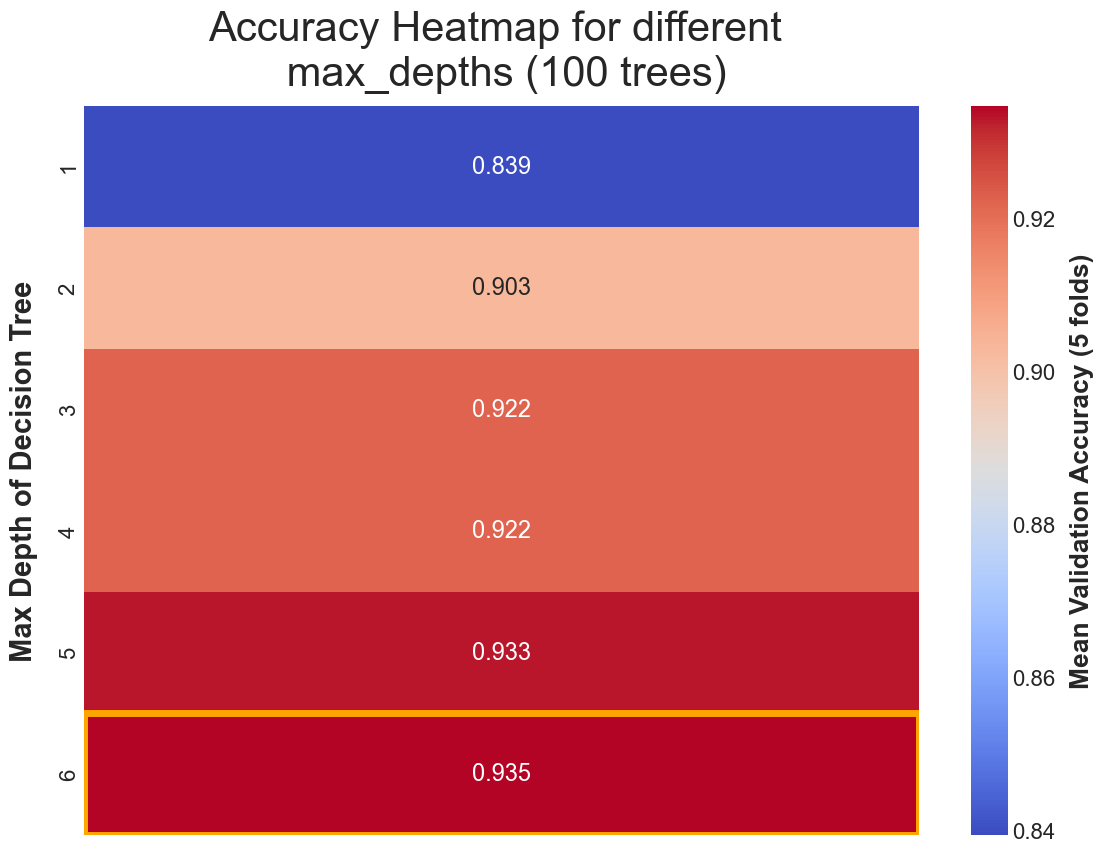

In [164]:
################### VALIDATION ACCURACY HEATMAP ######################

df_sorted = CVdataframe_RF.sort_values('param_max_depth')  # Sort by max_depth for better visualization


accuracy = df_sorted['mean_test_score']
depths = df_sorted['param_max_depth']

# Create a "flattened" heatmap
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 9))

sns.heatmap([[val] for val in accuracy], ax=ax, annot=True, fmt=".3f", cmap='coolwarm', 
            yticklabels=depths, annot_kws={"size": 17})

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Mean Validation Accuracy (5 folds)', fontsize=19, labelpad = 10, fontweight = 'bold')
cbar.ax.tick_params(axis='both', labelsize = 16)

ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xticks([], [])
ax.set_title("Accuracy Heatmap for different \n max_depths (100 trees)", fontsize = 30, pad = 15)
ax.set_ylabel("Max Depth of Decision Tree", fontsize = 21, labelpad = 15, fontweight = 'bold')
ax.add_patch(plt.Rectangle((0,optimalindexRF), 1, 1, fill=False, edgecolor='orange', lw=5))
plt.savefig(PATH_1 + "/Accuracy_heatmap_RF.png",bbox_inches='tight')
plt.show()



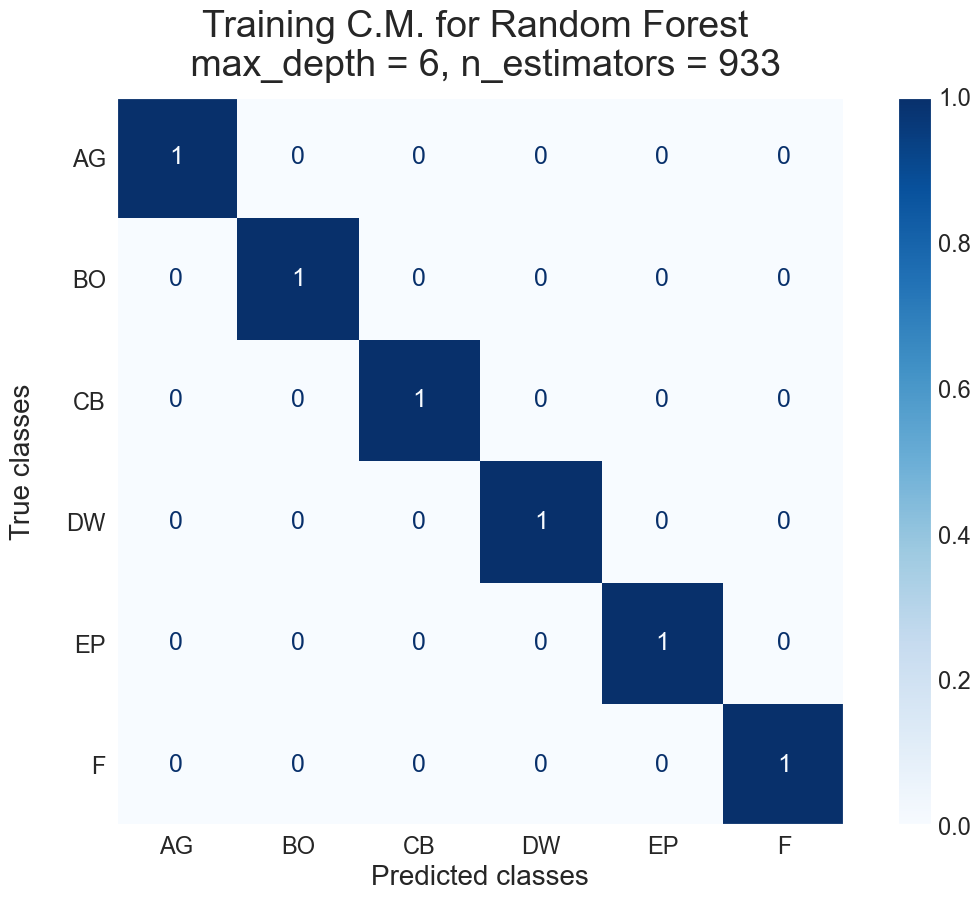

In [165]:
################## CONFUSION MATRICES ##################################################
sns.set_style('darkgrid')
fig0, ax0 = plt.subplots(figsize=(12, 9))
plt.grid()

classes = ['AG', 'BO', 'CB','DW','EP','F']
# Plot training confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_train, train_predictions_RF, ax=ax0, display_labels = classes, cmap='Blues', normalize = "true", text_kw = dict(fontsize = 18), colorbar = False)


image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.tick_params(labelsize = 17)

ax0.set_title(f'Training C.M. for Random Forest \n max_depth = {optimalparamsRF[0]}, n_estimators = {int(optimal_estimatorsRF)}', fontsize = 27, pad = 15)
ax0.tick_params(axis='both', which='both', length=0, labelsize = 17, pad = 7)
ax0.set_xlabel('Predicted classes', fontsize = 20)
ax0.set_ylabel('True classes', fontsize = 20, labelpad = 22)
plt.savefig(PATH_1 + "/Training_CM_RF.png", bbox_inches='tight', facecolor = 'white')
plt.show()

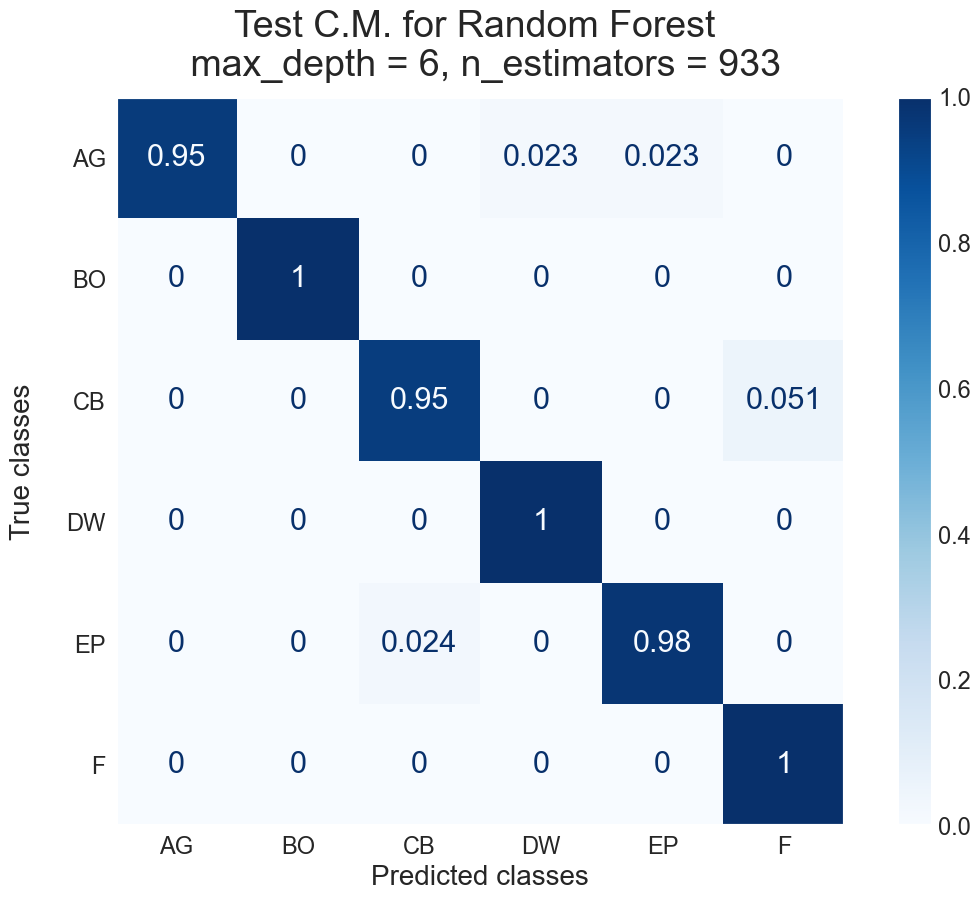

In [166]:
# Plot test confusion matrix
sns.set_style('darkgrid')
fig1, ax1 = plt.subplots(figsize=(12, 9))
plt.grid()
disp = ConfusionMatrixDisplay.from_predictions(y_test, test_predictions_RF, ax=ax1, display_labels = classes, cmap='Blues', normalize = "true", text_kw = dict(fontsize = 22), colorbar = False)


image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.tick_params(labelsize = 17)

ax1.set_title(f'Test C.M. for Random Forest \n max_depth = {optimalparamsRF[0]}, n_estimators = {int(optimal_estimatorsRF)}', fontsize = 27, pad = 15)
ax1.tick_params(axis = 'both', which = 'both', length = 0, labelsize = 17, pad = 7)
ax1.set_xlabel('Predicted classes', fontsize = 20)
ax1.set_ylabel('True classes', fontsize = 20, labelpad = 22)
plt.savefig(PATH_1 + "/Test_CM_RF.png",bbox_inches='tight', facecolor = 'white')
plt.show()

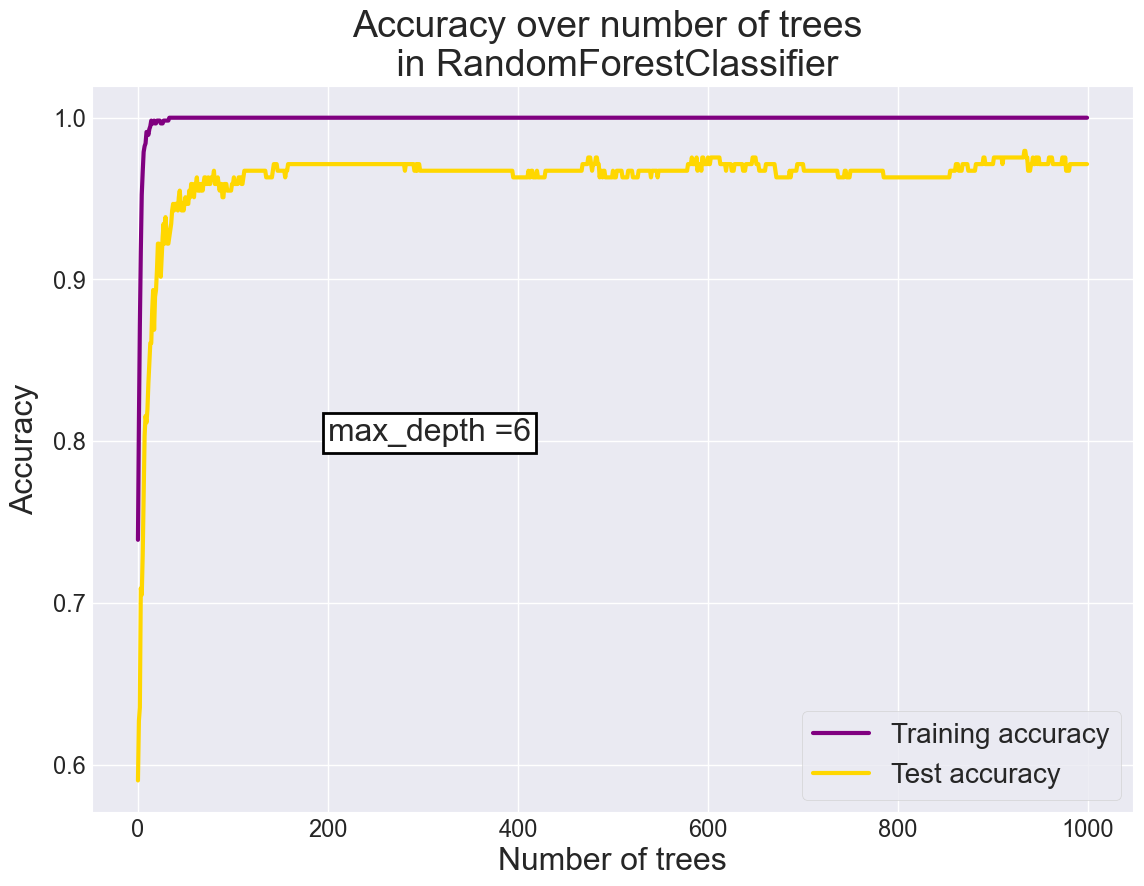

In [167]:
########################### CROSS ENTROPY AND ACCURACY OVER ROUNDS #######################################
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
plt.figure(1, figsize = (12, 9))

fig = plt.gcf()

fig.patch.set_facecolor('white')

plt.plot(range(0,1000), train_accs_RF, color = 'purple', label = 'Training accuracy', linewidth = 3)
plt.plot(range(0,1000), test_accs_RF, color = 'gold', label = 'Test accuracy', linewidth = 3)
plt.legend(fontsize = 20)
plt.text(200, 0.8, f'max_depth ={optimalparamsRF[0]}', fontsize = 23, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.title(f'Accuracy over number of trees \n in RandomForestClassifier', fontsize = 27)
plt.tick_params(axis = 'both', labelsize = 17)
plt.xlabel('Number of trees', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 23, labelpad = 10)
plt.savefig(PATH_2 + "/Accuracy_over_estimators_RF.png", bbox_inches='tight', facecolor = 'white')
plt.show()

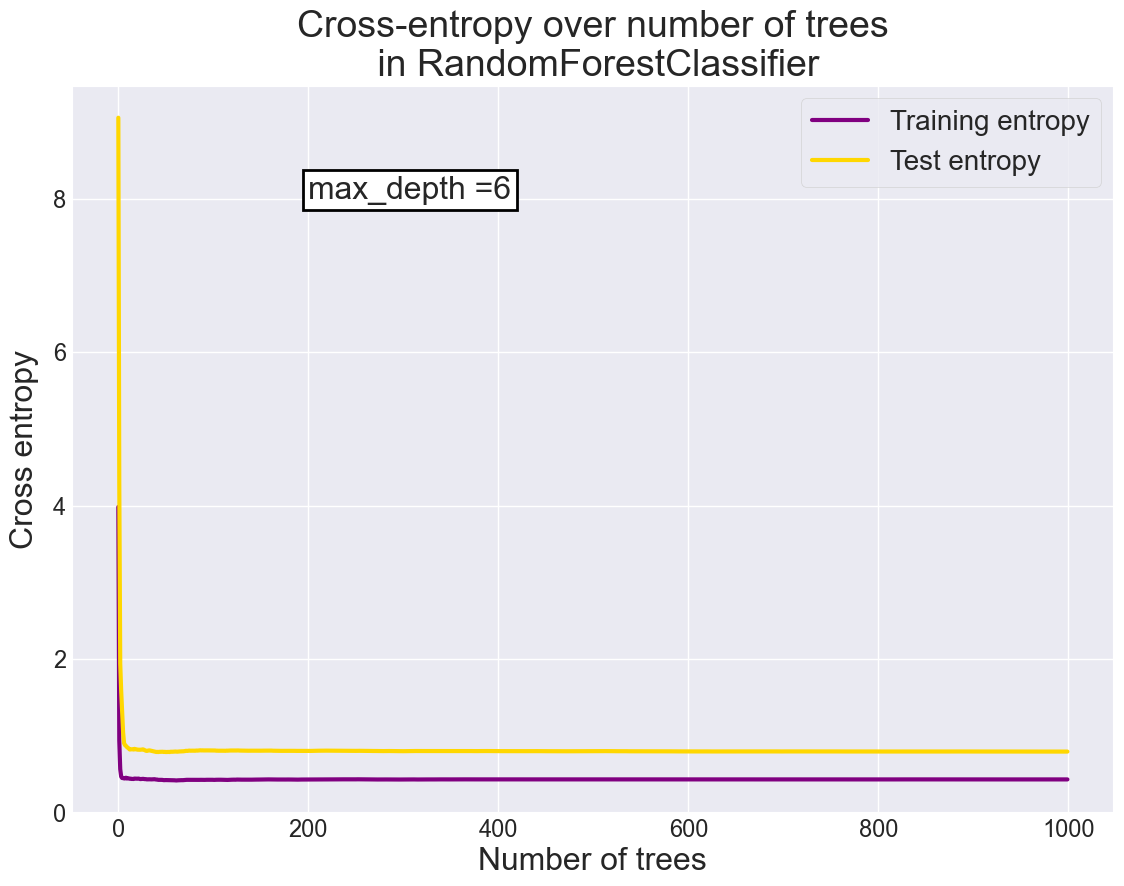

In [168]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
plt.figure(1, figsize = (12, 9))

fig = plt.gcf()

fig.patch.set_facecolor('white')

plt.plot(range(0,1000), train_errors_RF, label = 'Training entropy', color='purple', linewidth = 3)
plt.plot(range(0,1000), test_errors_RF, label = 'Test entropy', color='gold', linewidth = 3)
plt.legend(fontsize = 20)
plt.title(f'Cross-entropy over number of trees\n in RandomForestClassifier', fontsize = 27)
plt.text(200, 8, f'max_depth ={optimalparamsRF[0]}', fontsize = 23, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 17)
plt.xlabel('Number of trees', fontsize = 23)
plt.ylabel('Cross entropy', fontsize = 23, labelpad = 10)
plt.savefig(PATH_2 + "/Entropy_over_estimators_RF.png", bbox_inches='tight', facecolor = 'white')
plt.show()

## Plots for XGBCLassifier

The code in the cell below follows pretty much the same mold as the "RandomForestClassifier" plotting cell (i.e., the relevant files are re-loaded and the data is re-split, to avoid having to retrain the models if one wants to edit the plots). Keep in mind that the initial cell with the imports must still be ran, however.

Five plots are generated:

* A heatmap of the validation accuracy values obtained for all combinations of learning_rate and reg_lambda. This is why we saved the index position of the best parameters, so the best accuracy score can be highlighted in our heatmap;
* 2 confusion matrices, 1 for training data and 1 for testing data, utilizing the optimal iteration found by LossAccuracyOverRounds. They are produced utilizing the from_predictions method - hence why we saved these predictions as .npy files;
* Plots of both the accuracy and the cross-entropy for training and testing data as more boosting rounds are performed. These plots are why we saved the 4 numpy arrays in the "LossAccuracyOverRounds" function.

The heatmap and confusion matrices are saved to "Results_Ensemble/GridSearchXGB". The accuracy and entropy curves are saved to "Results_Ensemble/LossAccuracyXGB".

In [170]:
features = np.load('Results_Ensemble/features.npy')
categories = np.load('Results_Ensemble/categories.npy')

categories = categories.flatten()
# Splitting dataset
strat = categories
x_train, x_test, y_train, y_test = train_test_split(features, categories, test_size=.3, shuffle=True, stratify=strat, random_state=123)

PATH_3 = "Results_Ensemble/GridSearchXGB"
PATH_4 = "Results_Ensemble/LossAccuracyXGB"

CVdataframe_XGB = pd.read_csv(PATH_3 + '/crossval_XGB.csv')

with open(PATH_3 + '/Best_settings_XGB.txt','r') as file:
    lines = file.readlines()
    optimalparamsXGB = [float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(',')]
    optimalindexXGB = [int(i) for i in lines[2].split(':')[1].lstrip(' (').rstrip(')').split(',')]

strat = categories
x_train, x_test, y_train, y_test = train_test_split(features, categories, test_size=.3, shuffle=True, stratify=strat, random_state=123)

with open(PATH_4 + '/Best_iteration_XGB.txt','r') as file:
    lines = file.readlines()
    optimal_iterationXGB, optimal_accuracyXGB = (float(i.split('=')[1].rstrip('\n')) for i in lines[0].split(':')[1].split(','))
    finaltrain_accuracyXGB, finaltest_accuracyXGB = (float(i.split('=')[1].rstrip('\n')) for i in lines[1].split(':')[1].split(','))

print(f"XGBoost: Optimal iteration: {optimal_iterationXGB}, with a test accuracy of  {optimal_accuracyXGB}")
print(f"XGBoost: Final training accuracy: {finaltrain_accuracyXGB}, final test accuracy: {finaltest_accuracyXGB}")

train_predictions_XGB = np.load(PATH_4 + '/best_train_XGB.npy')
test_predictions_XGB = np.load(PATH_4 + '/best_test_XGB.npy')

train_accs_XGB, train_errors_XGB = np.load(PATH_4 + '/train_accs_XGB.npy'), np.load(PATH_4 + '/train_errors_XGB.npy')
test_accs_XGB, test_errors_XGB = np.load(PATH_4 + '/test_accs_XGB.npy'), np.load(PATH_4 + '/test_errors_XGB.npy')

XGBoost: Optimal iteration: 120.0, with a test accuracy of  0.9672131147540983
XGBoost: Final training accuracy: 1.0, final test accuracy: 0.9672131147540983


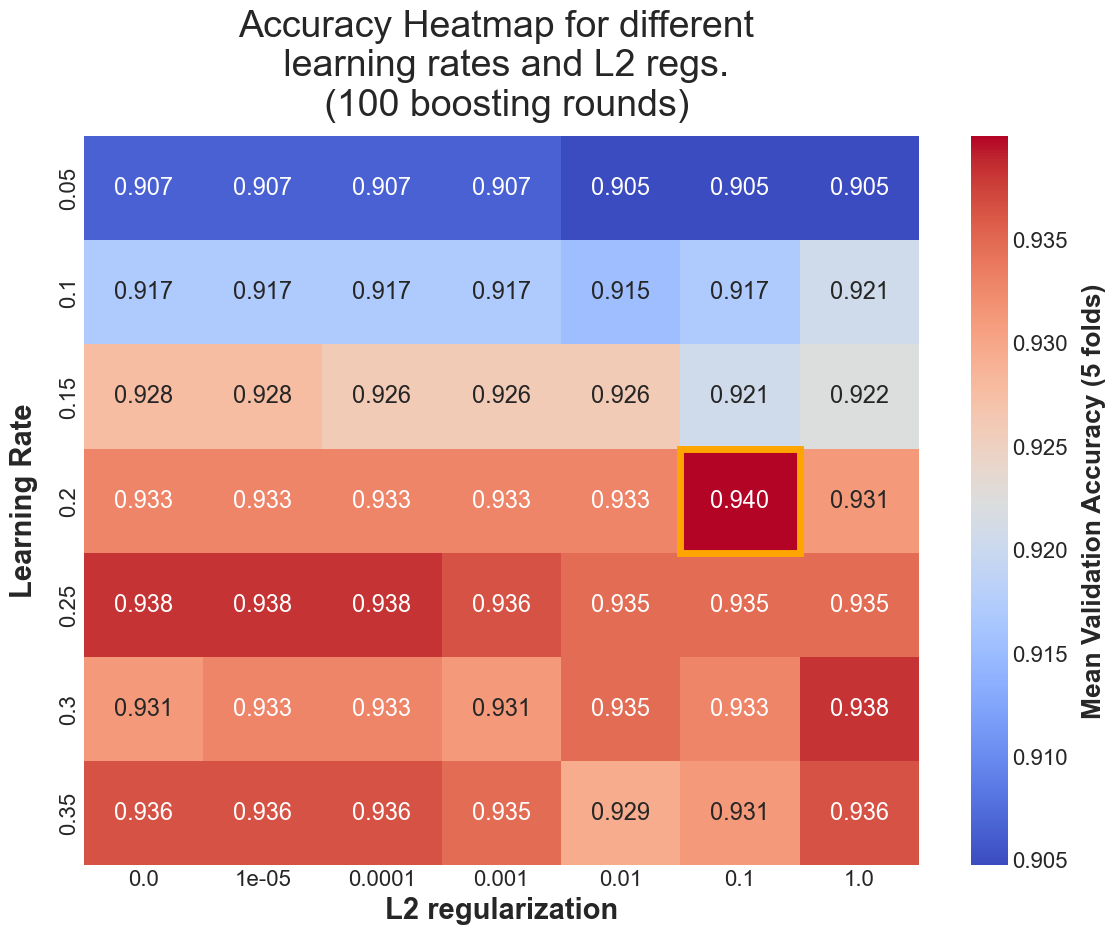

In [171]:
################### VALIDATION ACCURACY HEATMAP ######################

heatmap_data = CVdataframe_XGB.pivot(index = 'param_learning_rate', columns = 'param_reg_lambda', values = 'mean_test_score')

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(heatmap_data, ax = ax, annot=True, fmt=".3f", cmap="coolwarm", annot_kws={"size": 17})

cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel('Mean Validation Accuracy (5 folds)', fontsize=19, labelpad = 10, fontweight = 'bold')
cbar.ax.tick_params(axis='both', labelsize = 16)

ax.tick_params(axis = 'both', labelsize = 16)
ax.set_title("Accuracy Heatmap for different \n learning rates and L2 regs.\n (100 boosting rounds)", fontsize = 27, pad = 15)
ax.set_xlabel("L2 regularization", fontsize = 21, labelpad = 5, fontweight = 'bold')
ax.set_ylabel("Learning Rate", fontsize = 21, labelpad = 15, fontweight = 'bold')
ax.add_patch(plt.Rectangle((optimalindexXGB[1], optimalindexXGB[0]), 1, 1, fill=False, edgecolor='orange', lw=5))
plt.savefig(PATH_3 + "/Accuracy_heatmap_XGB.png", bbox_inches='tight')
plt.show()

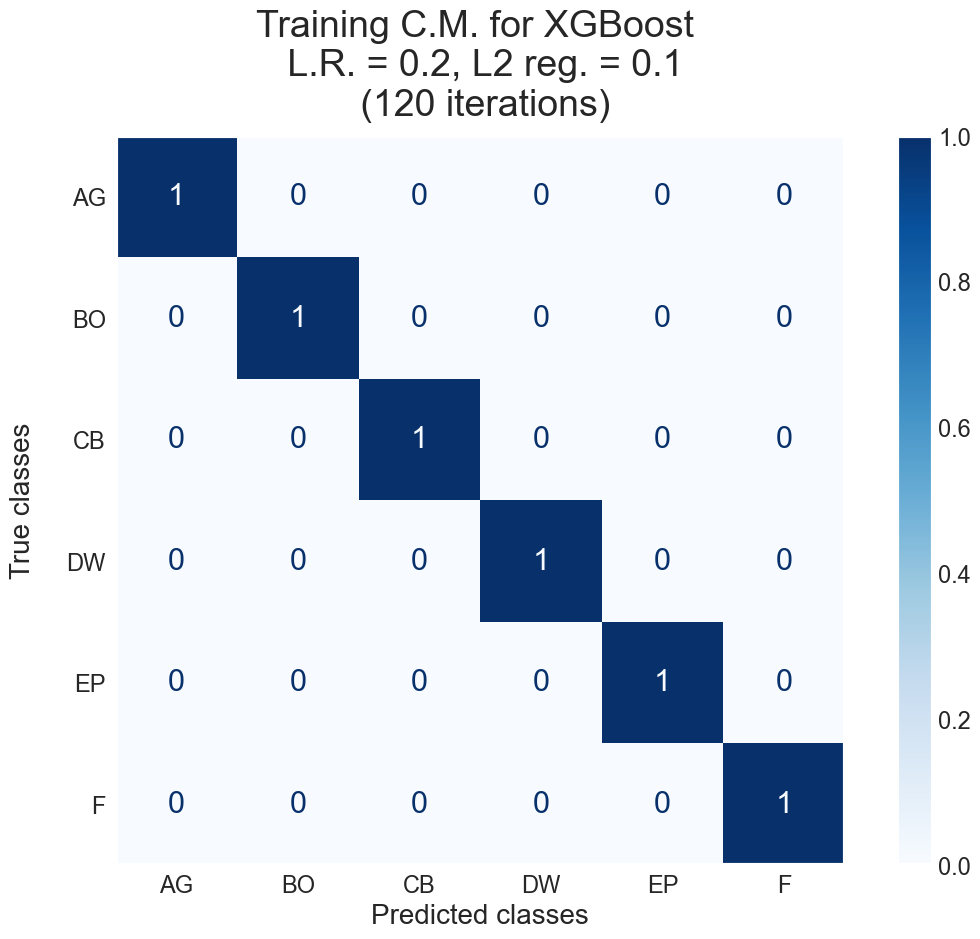

In [172]:
################## CONFUSION MATRICES ##################################################
sns.set_style('darkgrid')
fig0, ax0 = plt.subplots(figsize=(12, 9))
plt.grid()

classes = ['AG', 'BO', 'CB','DW','EP','F']
# Plot training confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_train, train_predictions_XGB, ax=ax0, display_labels = classes, cmap='Blues', normalize = "true", text_kw = dict(fontsize = 22), colorbar = False)

image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.tick_params(labelsize = 17)

ax0.set_title(f'Training C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}\n ({int(optimal_iterationXGB)} iterations)', fontsize = 27, pad = 15)
ax0.tick_params(axis='both', which='both', length=0, labelsize = 17, pad = 7)
ax0.set_xlabel('Predicted classes', fontsize = 20)
ax0.set_ylabel('True classes', fontsize = 20, labelpad = 22)
plt.savefig(PATH_3 + "/Training_CM_XGB.png", bbox_inches='tight', facecolor = 'white')
plt.show()

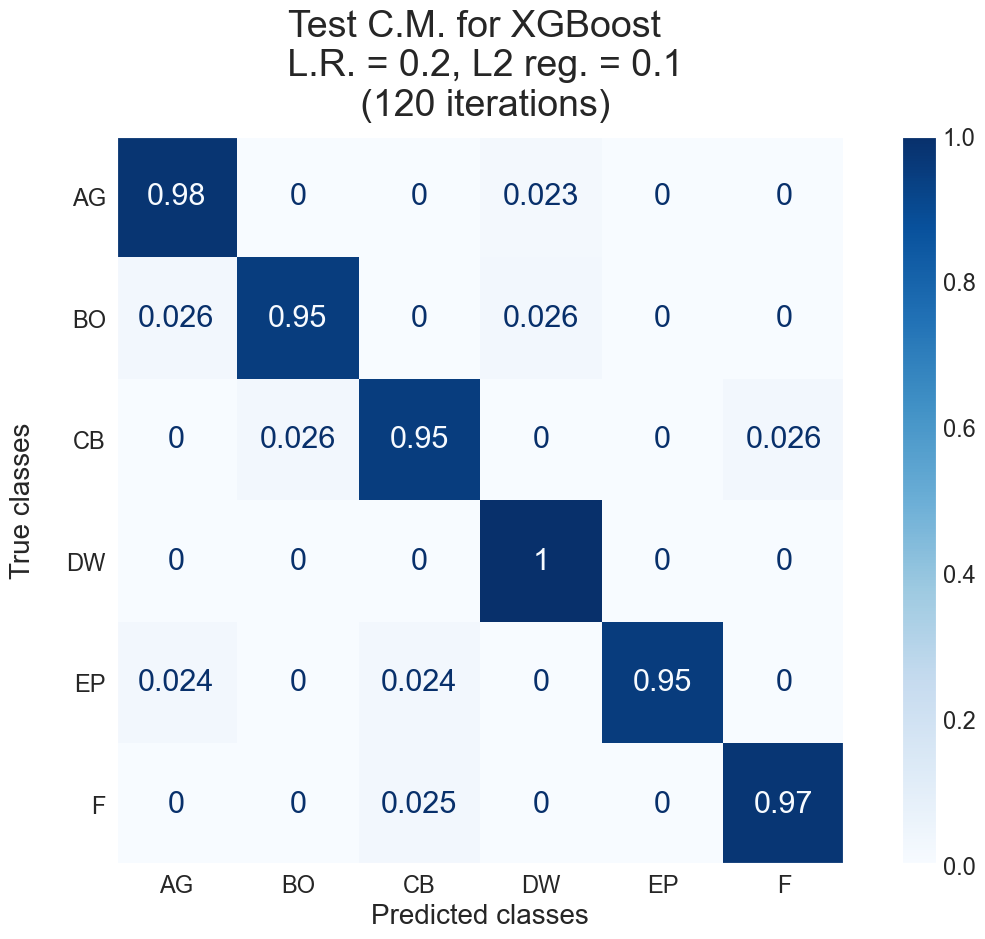

In [173]:
sns.set_style('darkgrid')
fig1, ax1 = plt.subplots(figsize=(13, 9))
plt.grid()

disp = ConfusionMatrixDisplay.from_predictions(y_test, test_predictions_XGB, ax=ax1, display_labels = classes, cmap='Blues', normalize = "true", text_kw = dict(fontsize = 22), colorbar = False)


image = disp.im_

cbar = disp.ax_.figure.colorbar(image, ax=disp.ax_)
cbar.ax.tick_params(labelsize = 17)

ax1.set_title(f'Test C.M. for XGBoost \n L.R. = {optimalparamsXGB[0]}, L2 reg. = {optimalparamsXGB[1]}\n ({int(optimal_iterationXGB)} iterations)', fontsize = 27, pad = 15)
ax1.tick_params(axis = 'both', which = 'both', length = 0, labelsize = 17, pad = 7)
ax1.set_xlabel('Predicted classes', fontsize = 20)
ax1.set_ylabel('True classes', fontsize = 20, labelpad = 22)
plt.savefig(PATH_3 + "/Test_CM_XGB.png", bbox_inches='tight', facecolor = 'white')
plt.show()

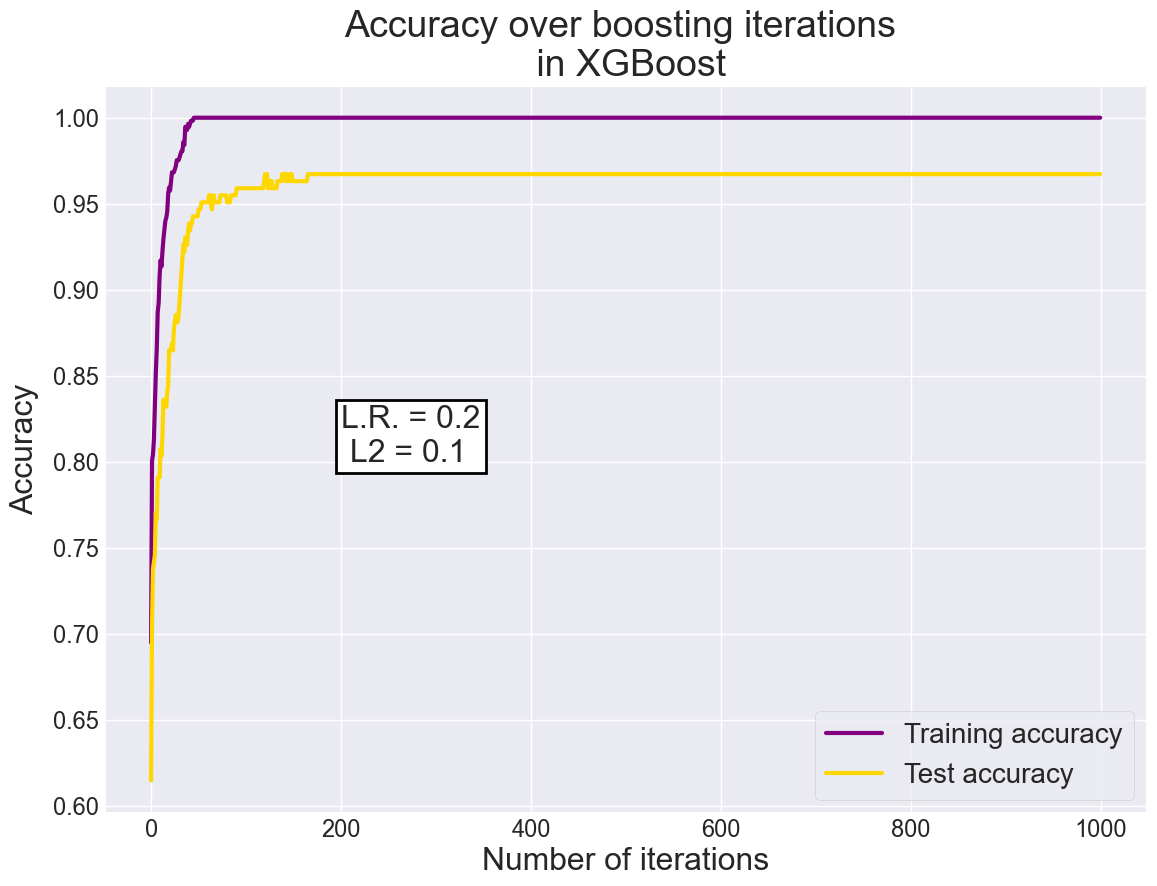

In [174]:
########################### CROSS ENTROPY AND ACCURACY OVER ROUNDS #######################################
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
plt.figure(1, figsize = (12, 9))

fig = plt.gcf()

fig.patch.set_facecolor('white')

plt.plot(range(0,1000), train_accs_XGB, color = 'purple', label = 'Training accuracy', linewidth = 3)
plt.plot(range(0,1000), test_accs_XGB, color = 'gold', label = 'Test accuracy', linewidth = 3)
plt.legend(fontsize = 20)
plt.title(f'Accuracy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(200, 0.8, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 23, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 17)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Accuracy', fontsize = 23, labelpad = 10)
plt.savefig(PATH_4 + "/Accuracy_over_estimators_XGB.png", bbox_inches='tight', facecolor = 'white')
plt.show()

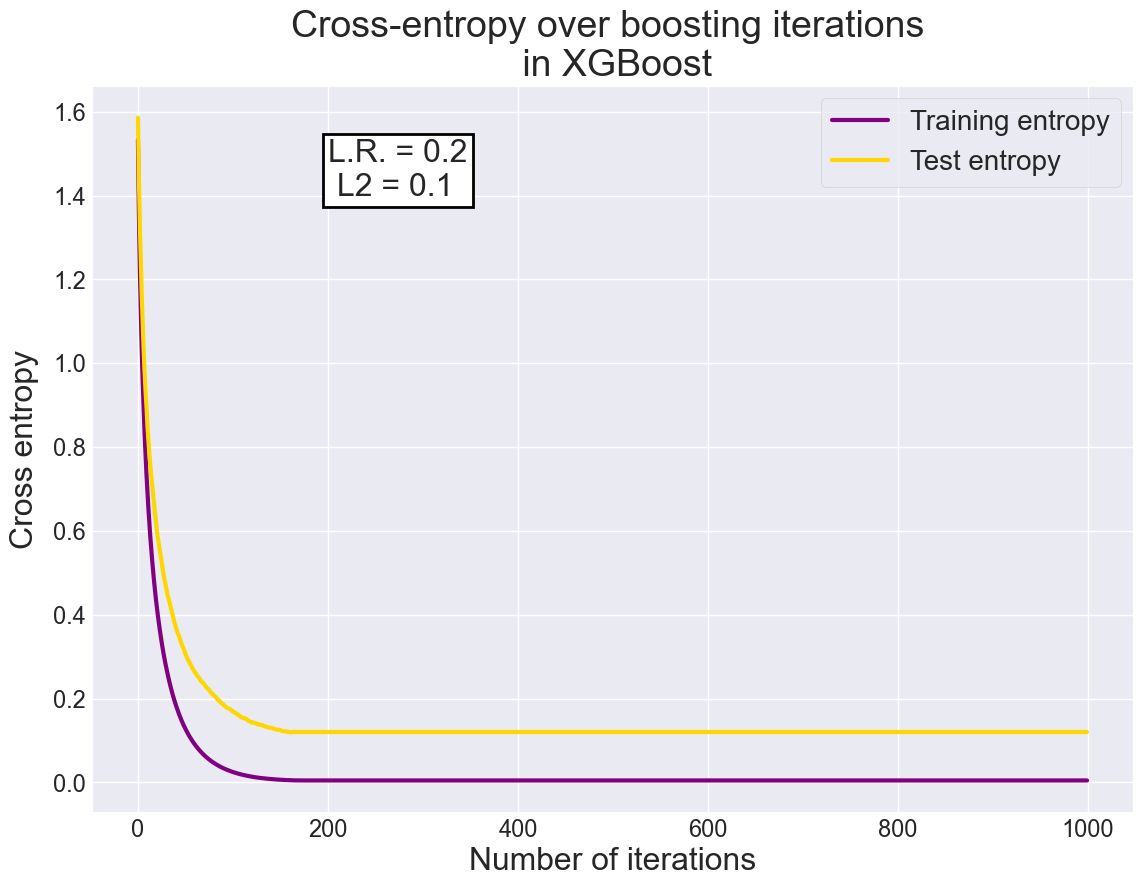

In [175]:
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
plt.figure(1, figsize = (12, 9))

fig = plt.gcf()

fig.patch.set_facecolor('white')

plt.plot(range(0,1000), train_errors_XGB, color = 'purple', label = 'Training entropy', linewidth = 3)
plt.plot(range(0,1000), test_errors_XGB, color = 'gold', label = 'Test entropy', linewidth = 3)
plt.legend(fontsize = 20)
plt.title(f'Cross-entropy over boosting iterations \n in XGBoost', fontsize = 27)
plt.text(200, 1.4, f'L.R. = {optimalparamsXGB[0]}\n L2 = {optimalparamsXGB[1]}', fontsize = 23, bbox = dict(facecolor = "white", edgecolor = "black", linewidth = 2))
plt.tick_params(axis = 'both', labelsize = 17)
plt.xlabel('Number of iterations', fontsize = 23)
plt.ylabel('Cross entropy', fontsize = 23, labelpad = 10)
plt.savefig(PATH_4 + "/Entropy_over_estimators_XGB.png", bbox_inches='tight', facecolor = 'white')
plt.show()